<a href="https://colab.research.google.com/github/Rajkadam21/CreditGuard-Predicting-Financial-Distress/blob/main/Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

In [2]:
df=pd.read_csv('cs-test-1.csv')

In [3]:
df

,ID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700,4,0,0,0,0
1,2,NaN,0.463295,57,0,0.527237,9141,15,0,4,0,2
2,3,NaN,0.043275,59,0,0.687648,5083,12,0,1,0,2
3,4,NaN,0.280308,38,1,0.925961,3200,7,0,2,0,0
4,5,NaN,1.000000,27,0,0.019917,3865,4,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
101498,101499,NaN,0.282653,24,0,0.068522,1400,5,0,0,0,0
101499,101500,NaN,0.922156,36,3,0.934217,7615,8,0,2,0,4
101500,101501,NaN,0.081596,70,0,836.000000,-1,3,0,0,0,-1
101501,101502,NaN,0.335457,56,0,3568.000000,-1,8,0,2,1,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    101503 non-null  int64  
 1   SeriousDlqin2yrs                      0 non-null       float64
 2   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 3   age                                   101503 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 5   DebtRatio                             101503 non-null  float64
 6   MonthlyIncome                         101503 non-null  int64  
 7   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 8   NumberOfTimes90DaysLate               101503 non-null  int64  
 9   NumberRealEstateLoansOrLines          101503 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 11  

In [5]:
df.isnull().sum()

,0
ID,0
SeriousDlqin2yrs,101503
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,0
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0


In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Load data
train_df = pd.read_csv("cs-training.csv")
test_df = pd.read_csv("cs-test-1.csv")


In [ ]:
# Preprocessing
X = train_df.drop(columns=["ID", "SeriousDlqin2yrs"])
y = train_df["SeriousDlqin2yrs"]
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [ ]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Convert to tensors and send to device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
# Dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
# MLP with ReLU
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [ ]:
# Initialize and move model to device
model = MLPModel(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
for epoch in range(10):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.1406
Epoch 2, Loss: 0.2078
Epoch 3, Loss: 0.2055
Epoch 4, Loss: 0.1148
Epoch 5, Loss: 0.2340
Epoch 6, Loss: 0.2160
Epoch 7, Loss: 0.1237
Epoch 8, Loss: 0.0683
Epoch 9, Loss: 0.3224
Epoch 10, Loss: 0.1681


In [ ]:
# Validation evaluation
model.eval()
with torch.no_grad():
    val_preds = model(X_val_tensor)
    val_preds_binary = (val_preds >= 0.5).float()
    acc = accuracy_score(y_val_tensor.cpu(), val_preds_binary.cpu())
    auc = roc_auc_score(y_val_tensor.cpu(), val_preds.cpu())
    print(f"\nValidation Accuracy: {acc:.4f}")
    print(f"Validation AUC: {auc:.4f}")



Validation Accuracy: 0.9366
Validation AUC: 0.8355


In [ ]:
# Test prediction
X_test = test_df.drop(columns=["ID", "SeriousDlqin2yrs"])
X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    test_probs = model(X_test_tensor)
    print("\nSample Test Predictions:", test_probs[:5].view(-1).tolist())



Sample Test Predictions: [0.027404995635151863, 0.04043202102184296, 0.01823996938765049, 0.09479838609695435, 0.0469098761677742]


In [ ]:
y_true = y_val_tensor.cpu().numpy()
y_pred = val_preds_binary.cpu().numpy()


<Figure size 600x500 with 0 Axes>

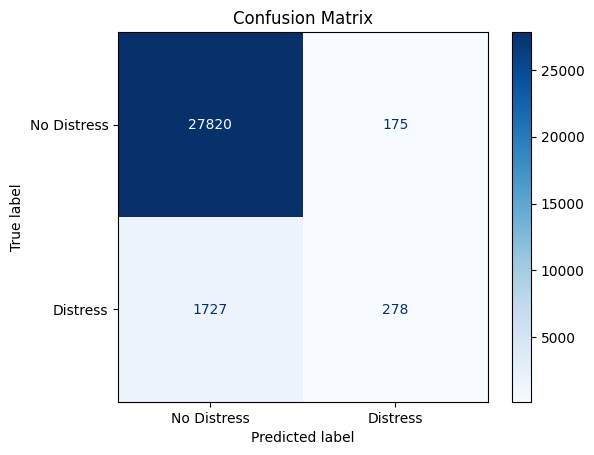

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Distress", "Distress"])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

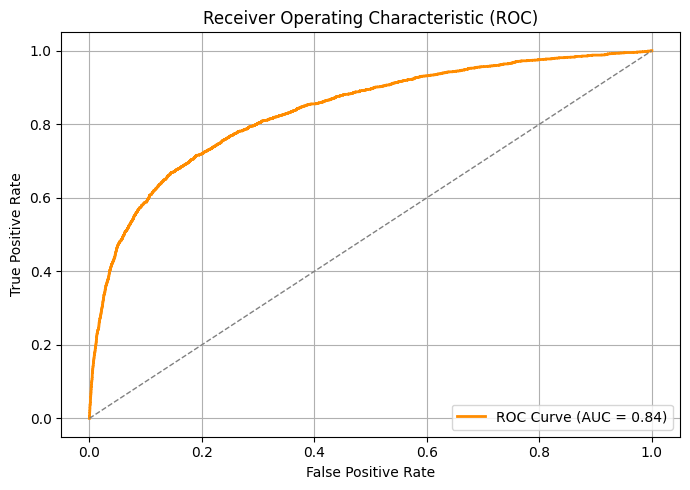

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr, tpr, _ = roc_curve(y_true, val_preds.cpu().numpy())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

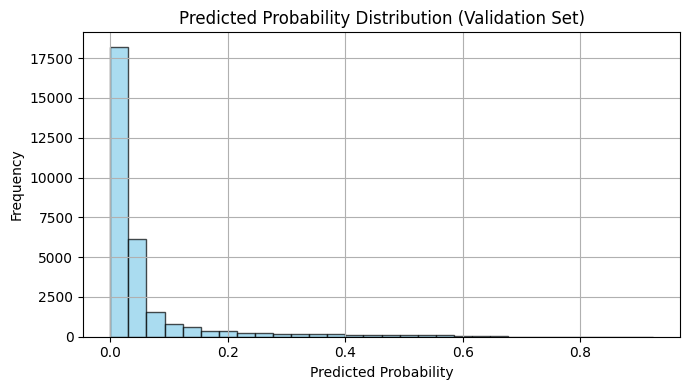

In [ ]:
plt.figure(figsize=(7, 4))
plt.hist(val_preds.cpu().numpy(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Predicted Probability Distribution (Validation Set)')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()